In [1]:
import pandas as pd
from typing import *
import re
# from fpgrowth_py import fpgrowth
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import split
# from pyspark.sql.types import ArrayType, StringType, StructField, StructType
import numpy as np
import matplotlib.pyplot as plt

In [2]:
files = pd.read_csv(r"../Generated_Result/10k.csv", sep=";").fillna("None")
obj = files.iloc[:, :3]
for col in obj.columns:
    obj[col] = obj[col].apply(lambda x: np.nan if "none" in x.lower() else x)

In [3]:
sets = obj.values.tolist()

In [4]:
np.isnan(sets[0][-1])
print(sets[0])

['Geological CO2 sequestration', 'Mitigation of anthropogenic carbon dioxide emissions|injection capacity and safety of the storage system|fluid flow in porous media|etc', nan]


In [5]:
for idx, subset in enumerate(sets):
    subset = [val.split("|") for val in subset if not pd.isnull(val)]
    subset = [item.strip() for yitem in subset for item in yitem]
    sets[idx] = subset

In [6]:
from functools import singledispatch

@singledispatch
def myFunc(marker, val):
    print("This is the default function")

@myFunc.register(float)
def _(marker: float, val: List[str]):
    pattern = r'\b(?:yes|Yes|etc|-?\d+\.\d+|000)\b'
    processed_list = [item for item in val if not re.search(pattern, item)]
    return processed_list

@myFunc.register(int)
def _(marker: int, val: List[str]):
    print(fr"the marker type is {type(marker)}, it will clean the duplicated value.")
    pattern = r'\b(?:yes|Yes|etc|-?\d+\.\d+|000)\b'
    processed_list = [item for item in val if not re.search(pattern, item)]
    return list(set(processed_list))

In [7]:
testing_pattern = r"\b(?:yes|Yes|etc|-?\d+\.\d+|000)\b"
words1, word2, word3, word4 = "here is a pattern owns 1.0 and 2.0", \
                          "here is a pattern owns 1 and 2", \
                          "here is a pattern owns no number",\
                          "000"
for word in [words1, word2, word3, word4]:
    print(re.search(testing_pattern, word))

<re.Match object; span=(23, 26), match='1.0'>
None
None
<re.Match object; span=(0, 3), match='000'>


37 37


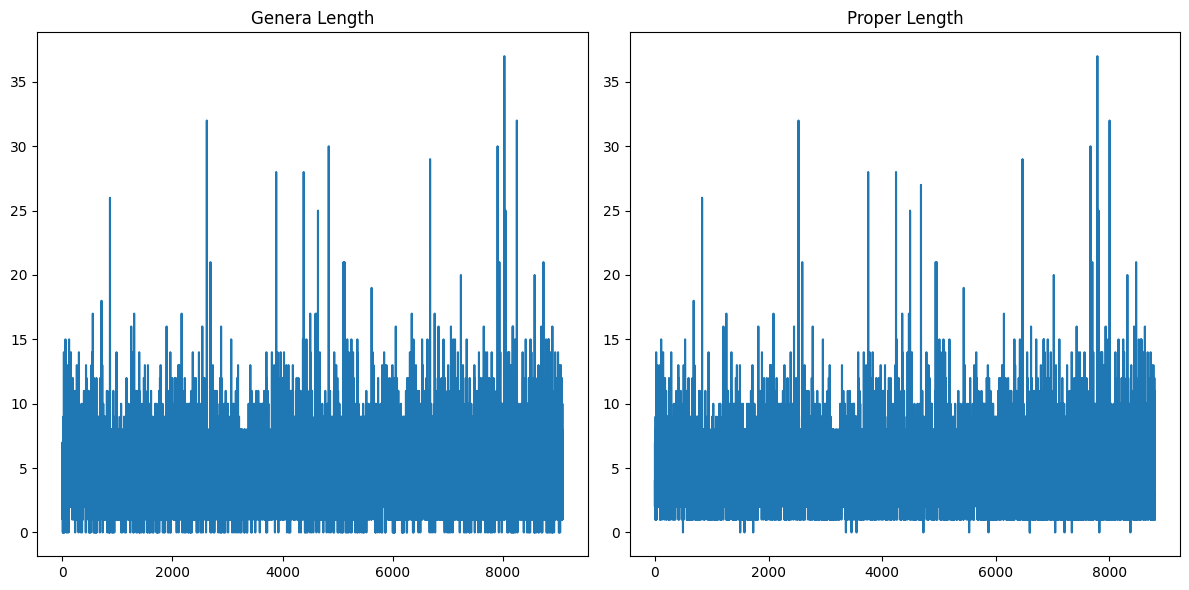

In [8]:
sets_proper = [myFunc(1.0, val) for val in sets if val ]
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
generaLength, properLength = [len(subitem) for subitem in sets], [len(subitem) for subitem in sets_proper]
print(max(generaLength), max(properLength))
ax[0].plot(generaLength)  # Plot the first horizontal bar chart
ax[0].set_title('Genera Length')  # Add a title to the first subplot

ax[1].plot(properLength)  # Plot the second horizontal bar chart
ax[1].set_title('Proper Length')  # Add a title to the second subplot

plt.tight_layout()  # Adjust the spacing between subplots if necessary
plt.show()  # Display the plot

In [9]:
# sets_proper = filter(myFunc, sets)
# sets_proper=list(sets_proper)

### FP Growth Testing

In [ ]:
import time
from utils import *
from my_fpgrowth import *
test_set = sets_proper[:1000]
time1 = time.time()
root = SycNode("root", None)
headerTable, root = general_call(test_set, 4, root=root)
print(f"Time taken is {time.time() - time1}")

In [18]:
innerTreeHook(root)

Root:  root
Childs are: researchers
Root:  researchers
Childs are: 


In [26]:
sets_proper[:10]

[['Geological CO2 sequestration',
  'Mitigation of anthropogenic carbon dioxide emissions',
  'injection capacity and safety of the storage system',
  'fluid flow in porous media'],
 ['development and validation of a discrete event microsimulation model',
  'commercial vehicles passing through the area'],
 ['Urban renaissance project in the area of Gazi',
  'Pollution from the industrial use of Gazi',
  'which has been a source of environmental degradation for the city of Athens and its surrounding area',
  'Residents of Gazi',
  'environmental activists',
  'local government officials',
  'and business owners who will be impacted by the proposed urban renaissance project'],
 ['simulation of changes in live carbon stocks in the Amazon Basin',
  'droughts',
  'forest ecosystem',
  'climate change'],
 ['Ecological enhancement of coastal and marine infrastructure (CMI',
  'degraded or reduced habitat for native species',
  'ecosystem and habitat value',
  'this paper presents the findings

FPGrowthModel: uid=FPGrowth_7868bf101870, numTrainingRecords=8802